<a href="https://colab.research.google.com/github/swapnilsethi/Effects-of-Twitter-Sentiments-on-the-Stock-Prices/blob/main/DMl_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing the Effects of Twitter Sentiments on the Stock Prices

### Team #: 10 
###Team Members- 

*   Avinash Bobbala
*   Gauthami Aithal
*   Shashikiran Peddireddy
*   Swapnil Sethi
*   Ujas Shah







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Motivation - https://aclanthology.org/S17-2088.pdf

In [ ]:
!pip install snscrape
!pip install psycopg2
!pip install yfinance
!pip install nltk
!pip install transformers 
!pip install vaderSentiment

### Scraping data from Twitter

To get stock specific tweets data from twitter we looked into various options like twitter API, scrappers, available dataset etc. Due to API limitation for number of tweets we can fetch on daily and monthly basis as well as limitaiton on historical data, we decided to go with scraping option. We used available scrper snscrape for this. 

Snscrape is a scraper for social networking services (SNS). It scrapes things like user profiles, hashtags, or searches and returns the discovered items, e.g. the relevant posts. 

Document/github link - https://github.com/JustAnotherArchivist/snscrape

Requirements:

*   Python 3.8 or higher
*   lxml, libxml2 and libxslt python packages (Preinstalled with Python)



#### Import necessary libraries

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import snscrape.modules.twitter as sntwitter # 

from datetime import date, timedelta
import datetime


In [ ]:
import sys
old_stdout = sys.stdout

log_file = open("message.log","w") # log file generation to keep track of # of tweets fetched for each keyword and duration

sys.stdout = log_file

tweets_list2 = []
num_of_tweets = 5000  # Number of max tweets to fetch per day

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2020, 1, 1)   # start date from which we want to scrape data
end_date = date(2023, 4, 15)    # End date to which we want to scrape data

for single_date in daterange(start_date, end_date):
    
    since_ = single_date.strftime("%Y-%m-%d")
    next_day = single_date + datetime.timedelta(days=1)
    until_ = next_day.strftime("%Y-%m-%d")

    print(single_date.strftime("%Y-%m-%d"),' to ', next_day.strftime("%Y-%m-%d"))  # log message

    j = 0

    Tesla_related_list = ['$Tsla', '$tsla', '@Tsla', '#TSLA','@Tsla', '@tsla', '#tsla'] #different Tesla ticker/hashtag symbols used on twitter
    
    parsed_terms = []
    for term in Tesla_related_list:
        parsed_terms.append(term)
        if j <= num_of_tweets:
            print('Working with {}'.format(term)) #log message
            
            for i,tweet in enumerate(sntwitter.TwitterSearchScraper('{} since:{} until:{}'.format(term, since_, until_)).get_items()):
                if j>num_of_tweets:
                    print('Got my {} tweets for date: {} from the term/terms: {}'.format(num_of_tweets, since_, parsed_terms)) # log message
                    break
                if(tweet.lang == 'en'):  #filtering tweets only in English language
                    j+=1 
                    tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.retweetCount, tweet.lang, tweet.user.verified])
                
                
    print('Final val of j: {}'.format(j))    # log message
    if(j < num_of_tweets):
        print('Got {} tweets for date: {} from the term/terms: {}. Insufficient no. of valid Tweets!'.format(j, since_, parsed_terms)) # log message

# Creating a dataframe from the tweets list above
tweets_df = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'Retweet_count', 'Language', 'Verified'])

# Storing output in CSV file
filename = 'SNS_scraped_tweets.csv' 
tweets_df.to_csv(filename)

sys.stdout = old_stdout 

log_file.close() # log file save and close

### Upload tweet data on AWS PostgresQL database

[link text](https://)To store this data and use it for further use from anywhere, we decided to use AWS PostgreSQL database. We are using free tire of AWS PostgreSQL database for the same. 

Read more - https://aws.amazon.com/rds/free/

To push data from python to postgres we have used psycopg2 package. Its main features are the complete implementation of the Python DB API 2.0 specification and the thread safety (several threads can share the same connection)

Requirements

*  Python versions above 3.6
*  PostgreSQL server versions 7.4 or above
*  PostgreSQL client library version 9.1 or above

Read more -https://pypi.org/project/psycopg2/






#### Import necessary libraries

In [ ]:
import psycopg2   #PostgreSQL database adapter 
from psycopg2.extensions import register_adapter, AsIs 
psycopg2.extensions.register_adapter(np.int64, psycopg2._psycopg.AsIs)
psycopg2.extensions.register_adapter(np.bool_, psycopg2._psycopg.AsIs)

In [ ]:
# reading the csv into pandas df
tweet_df = pd.read_csv("/fakepath/Jupyter Notebooks/SNS_scraped_tweets.csv") # First we stored all data in the csv files and then uploaded on DB

However, this decision casued us some issues, and hence further cleaning required before pushing data to DB. Due to different approches to write tweets, delimiter was not able to identify specific break[oints and created a issue. We performed below operations to get rid of such rows.

In [ ]:
tweet_df= tweet_df[tweet_df['Datetime'] != 'topstonks']
tweet_df= tweet_df[tweet_df['Datetime'] != 'nan']
tweet_df= tweet_df.dropna()
tweet_df = tweet_df[tweet_df['Datetime'] != 'sleekoptions']
tweet_df = tweet_df[tweet_df['Datetime'] != 'X_Trades_Net']
tweet_df = tweet_df[tweet_df['Datetime'] != 'RealTrades3']

for index, row in tweet_df.iterrows():   #to remove incorrect formatted data from the dataframe
    if not re.search('(\d{4})-(\d{2})-(\d{2}) (\d{2}):(\d{2}):(\d{2})\+00:00$', str(row['Datetime'])): 
        print(index,row['Datetime'])  # Print error message
        tweet_df = tweet_df8.drop(index)

tweet_df['Datetime'] = pd.to_datetime(tweet_df['Datetime']).dt.date. #Convert to Date

In [ ]:
tweet_df =tweet_df.drop(['Unnamed: 0','Language','Tweet Id'], axis=1) # remove unnecessary columns
tweet_df['Retweet_count'] = tweet_df['Retweet_count'].fillna(0)  # fill na with 0
tweet_df['Retweet_count'] = tweet_df['Retweet_count'].astype('int') # convert decimal to int

In [ ]:

# Initial DB table setup
# Connecting to DB
conn = psycopg2.connect(host = "database-1.ctixycpwks1a.us-east-1.rds.amazonaws.com", database = "dataminingprojectdb", port = "5432", user = "postgres", password = "Amazon2525*")

# Table creation only if it doesen't exist already!
# Tweet_Id should be unique, this prevent duplicate entries into the DB
commands = (# Table 1         
            '''Create Table IF NOT EXISTS Tesla_tweets(
                Datetime TEXT, 
                text TEXT,
                Username TEXT,
                Retweet_count BIGINT,  
                Verified TEXT );''')

# Creating a cursor to execute sql commands
cur = conn.cursor()
cur.execute(commands)

conn.commit()
cur.close()
conn.close()


# Function to push rows to DB
def dbconnect(Datetime, Text, Username, Retweet_count, Verified):

    conn = psycopg2.connect(host = "database-1.ctixycpwks1a.us-east-1.rds.amazonaws.com", database = "dataminingprojectdb", port = "5432", user = "postgres", password = "Amazon2525*")
    cur = conn.cursor()

    command = '''INSERT INTO Tesla_tweets (Datetime, Text, Username, Retweet_count, Verified) VALUES (%s, %s, %s, %s, %s) ON CONFLICT DO NOTHING;'''
    cur.execute(command, (Datetime, Text, Username, Retweet_count, Verified))

    conn.commit()
    cur.close()
    conn.close()




# Datetime	Text	Username	Retweet_count	Verified	cleantext
for idx in tweet_df.index:
    # read each row of csv and push it to DB
    dbconnect(tweet_df['Datetime'][idx], tweet_df['Text'][idx], tweet_df['Username'][idx], tweet_df['Retweet_count'][idx],tweet_df['Verified'][idx])
    
                
             

### Fetch Tesla Stock Data 

To fetch Tesla stock data, we have used Yahoo Finance library.  Ticker symbol for Tesla is 'TSLA'

Read more -https://pypi.org/project/yfinance/

In [ ]:
import yfinance as yahooFinance 
 
GetTeslaInformation = yahooFinance.Ticker("TSLA")

# Creating a dataframe from the tweets list above
tesla_df = pd.DataFrame(GetTeslaInformation.history(period="max"))
filename = 'tesla_stock_price.csv'
tesla_df.to_csv(filename)

In [ ]:
tesla_df = tesla_df.reset_index()

In [ ]:
tesla_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29,3.80,5.00,3.51,4.78,93831500,0,0.00
1,2010-06-30,5.16,6.08,4.66,4.77,85935500,0,0.00
2,2010-07-01,5.00,5.18,4.05,4.39,41094000,0,0.00
3,2010-07-02,4.60,4.62,3.74,3.84,25699000,0,0.00
4,2010-07-06,4.00,4.00,3.17,3.22,34334500,0,0.00


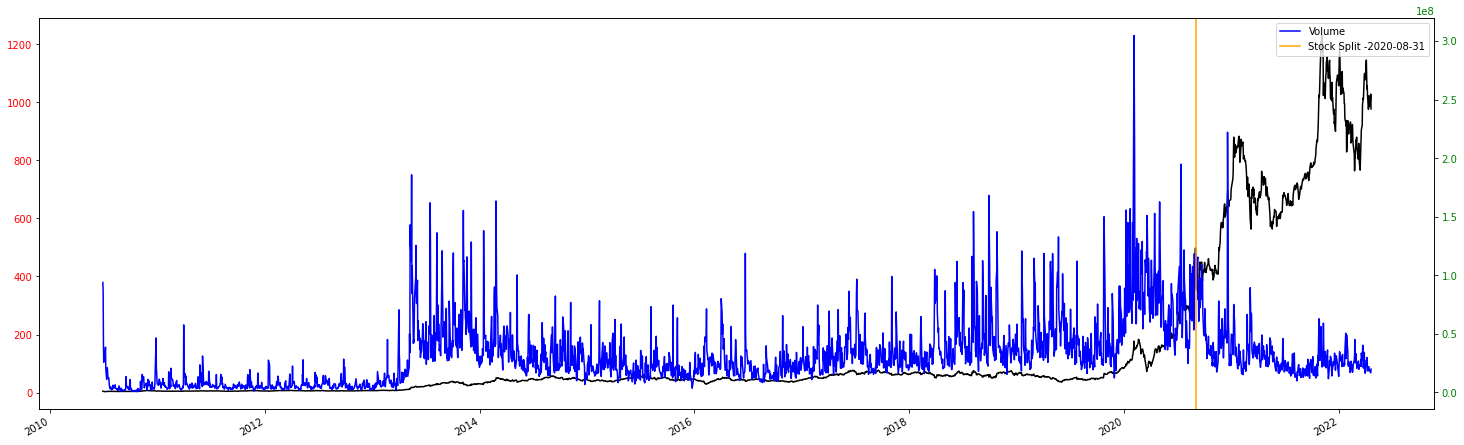

In [ ]:
fig, ax = plt.subplots(figsize=(25, 8)) 
ax.plot(tesla_df['Date'],tesla_df['Close'], color='black', label = 'Close Price')
ax.tick_params(axis='y', labelcolor='red')
ax2 = ax.twinx()
ax2.plot(tesla_df['Date'],tesla_df['Volume'], color='blue', label = 'Volume')
ax2.tick_params(axis='y', labelcolor='green')
plt.axvline(x= dt.datetime(2020,8, 31), label = 'Stock Split -2020-08-31', color = 'orange')

fig.autofmt_xdate()

plt.legend()
plt.show()

Tesla stock has been split one time since it went public. From above graph we can see that our data has been alreday adjusted according to stock split and hence we can't see major changes in stock price reduction or volume growth 

From above graph, we can also see that Tesla started getting momentum from 2020 onwards. Hence, we have decided to analyze the impact of twitter sentiment from 2020 onwards 

In [ ]:
tesla_df = tesla_df[tesla_df["Date"] >= '2020-01-01']

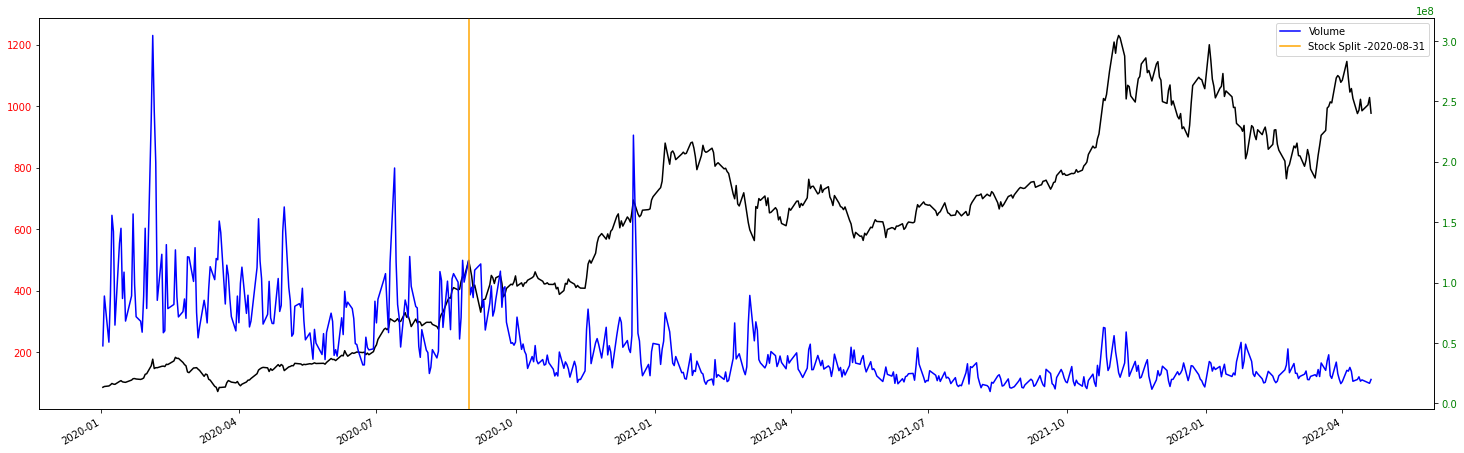

In [ ]:
fig, ax = plt.subplots(figsize=(25, 8)) 
ax.plot(tesla_df['Date'],tesla_df['Close'], color='black', label = 'Close Price')
ax.tick_params(axis='y', labelcolor='red')
ax2 = ax.twinx()
ax2.plot(tesla_df['Date'],tesla_df['Volume'], color='blue', label = 'Volume')
ax2.tick_params(axis='y', labelcolor='green')
plt.axvline(x= dt.datetime(2020,8, 31), label = 'Stock Split -2020-08-31', color = 'orange')

fig.autofmt_xdate()

plt.legend()
plt.show()

We will need how much stock has moved from previous day and in which direction to compare with sentiment score.

In [ ]:
tesla_df['Change'] = tesla_df['Close'] - tesla_df.Close.shift()

In [ ]:
tesla_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change
2394,2020-01-02,84.90,86.14,84.34,86.05,47660500,0,0.00,NaN
2395,2020-01-03,88.10,90.80,87.38,88.60,88892500,0,0.00,2.55
2396,2020-01-06,88.09,90.31,88.00,90.31,50665000,0,0.00,1.71
2397,2020-01-07,92.28,94.33,90.67,93.81,89410500,0,0.00,3.50
2398,2020-01-08,94.74,99.70,93.65,98.43,155721500,0,0.00,4.62


In [ ]:
conditions = [
    (tesla_df['Change'] <= 0.0),
    (tesla_df['Change'] > 0.0)
    ]
Values =[0,1]

tesla_df['Actual_sentiment'] = np.select(conditions, Values)

In [ ]:
tesla_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,Actual_sentiment
2394,2020-01-02,84.90,86.14,84.34,86.05,47660500,0,0.00,NaN,0
2395,2020-01-03,88.10,90.80,87.38,88.60,88892500,0,0.00,2.55,1
2396,2020-01-06,88.09,90.31,88.00,90.31,50665000,0,0.00,1.71,1
2397,2020-01-07,92.28,94.33,90.67,93.81,89410500,0,0.00,3.50,1
2398,2020-01-08,94.74,99.70,93.65,98.43,155721500,0,0.00,4.62,1


### Read data from PostgreSQL

To read data from PostgreSQL we are using, same library psycopg2, which we used for write.

In [ ]:
# Connecting to DB
conn = psycopg2.connect(host = "database-1.ctixycpwks1a.us-east-1.rds.amazonaws.com", database = "dataminingprojectdb", port = "5432", user = "postgres", password = "Amazon2525*")

cur = conn.cursor() ## Creating a cursor to execute sql commands
cur.execute('''select * from  public."Tesla_tweets" ''') # sql command to read data
df = cur.fetchall()
conn.commit()
cur.close()
conn.close()

In [ ]:
df = pd.DataFrame(df, columns =['Date', 'Text', 'User', 'Retweet_count','Verified'])

In [ ]:
df.head()

,Date,Text,User,Retweet_count,Verified
0,2022-01-01,Stocks cannot go up long on pump-and-dumps and...,TicTocTick,41,False
1,2022-01-01,$TSLA Ready for these numbers 📈📈 🥇,KFrounchi,0,False
2,2022-01-01,2022 THEMES (part 1)\n—- \n🇨🇳 China strengthen...,commandenteSD,3,False
3,2022-01-01,@strikingeagle9 @garyblack00 $TSLA will be the...,vtnicholas,0,False
4,2022-01-01,@yoloption @mark_mtv3 @GerberKawasaki @mrlevin...,italianmaster,0,False


We tried to perform sentiment analysis on whole dataset, however due to computational challenges, we are not able to perform sentiment analysis on whole data set. Hence, we decided to perform sentiment analysis on tweets made by verified tweeter users. In next step I'm only selecting tweets from verified users (Blue tick users)

and a lot of the non verified tweets are not useful to make predicitons in the first place

In [ ]:
df.shape

(3992487, 5)

In [ ]:
df = df[df['Verified']=="True"]

In [ ]:
df.shape

(65189, 5)

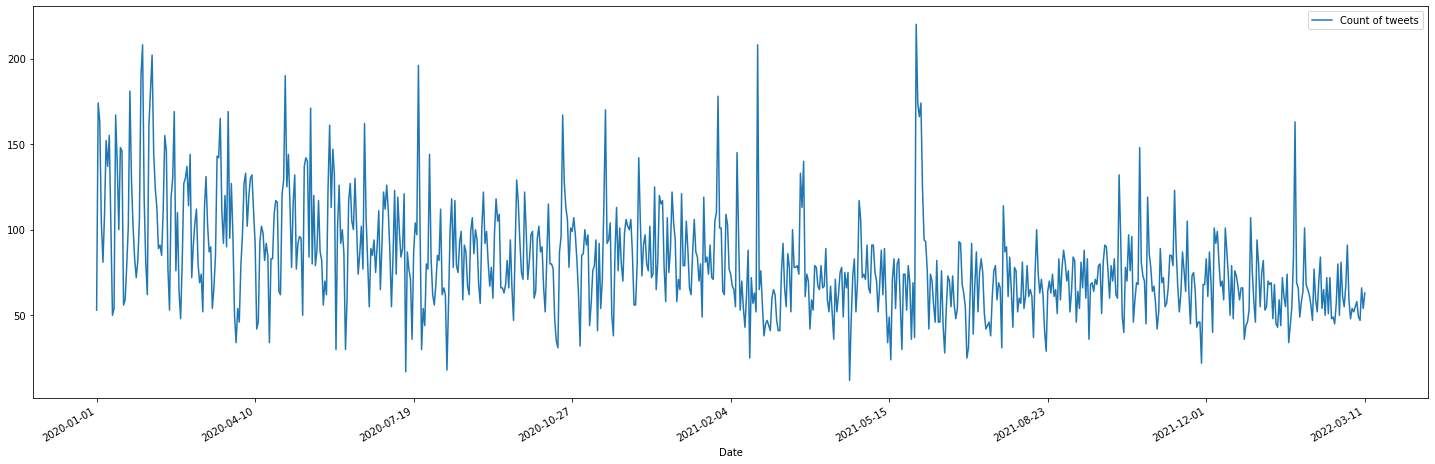

In [ ]:
fig, ax = plt.subplots(figsize=(25, 8)) 
df.groupby('Date')['Text'].count().plot( label= 'Count of tweets')
fig.autofmt_xdate()
plt.legend()
plt.show()

We have avg 100 daily tweets from verified users related with Tesla stock. 

### Tweet Cleaning

A tweet can contain a lot of things, from plain text, mentions, hashtags, links, punctuations to many other things. Before we perform sentiment analysis it's important to remove all these things from it. 
Also, we have to remove stop words from the text as they do not help us to determine sentiment of sentence. 

It is also important to break down the word into a simpler form e.g. giving to give. This process is called as stemmering. We are using Snowaball stemmer package available in the nltk library

In [ ]:
import re
import nltk
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")  # to convert words to root words
from nltk.corpus import stopwords   
import string
stopword=set(stopwords.words('english')) #english stop word dictionary

def clean(text):
    text = str(text).lower()   #convert to lower case
    text = re.sub('\[.*?\]', '', text) # remove punctuations
    text = re.sub('@[^\s]+','',text)  #remove tagged user
    text = re.sub('https?://\S+|www\.\S+', '', text) #remove URLs
    text = re.sub('<.*?>+', '', text) 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword] # word toeknization and removal of stop words
    text=" ".join(text) #join words again to form string
    text = [stemmer.stem(word) for word in text.split(' ')] # stemmer - convert words to root words
    text=" ".join(text)
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df["clean_text"] = df["Text"].apply(clean)

In [ ]:
df.head()

,Date,Text,User,Retweet_count,Verified,clean_text
120,2022-01-01,@coL_Fantasy @HuNteR_Jjx @saraharidgeway @Comp...,thyAshes,0,True,tri get rid sir
145,2022-01-01,"Reflecting on 2021, I had a pretty great year....",thyAshes,0,True,reflect pretti great year marri best friend ...
152,2022-01-01,Benzinga Bulls And Bears Of The Past Week: Dis...,Benzinga,9,True,benzinga bull bear past week disney ford carni...
178,2022-01-01,The Model Y is the second @Tesla to score an @...,CARandDRIVER,7,True,model second score top safeti pick award
219,2022-01-01,@rodmacpherson @Tesla And I'm not alone. 70% o...,tommolog,0,True,im alon respond think theyll deliv year


Now, we have done all the necessary steps to clean the data and are now in position to perform sentiment analysis. 

## Sentiment Analysis

We decided to perform sentiment analysis using 3 different methods and compare them. We choose pre-trained models like Textblob library, VADER (Valence Aware Dictionary for Sentiment Reasoning) from NLTK library, and Roberta. 

### 1. **Textblob**

TextBlob is a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

Features
1. Noun phrase extraction
2. Part-of-speech tagging
3. Sentiment analysis
4. Classification (Naive Bayes, Decision Tree)

Learn more - https://textblob.readthedocs.io/en/dev/


In [ ]:
from textblob import TextBlob

In [ ]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# tweet_df['Subjectivity'] = tweet_df['clean_text'].apply(getSubjectivity)
df['TextBlob_sentiment_score'] = df['clean_text'].apply(getPolarity)

df.head()

,Date,Text,User,Retweet_count,Verified,clean_text,TextBlob_sentiment_score
120,2022-01-01,@coL_Fantasy @HuNteR_Jjx @saraharidgeway @Comp...,thyAshes,0,True,tri get rid sir,0.00
145,2022-01-01,"Reflecting on 2021, I had a pretty great year....",thyAshes,0,True,reflect pretti great year marri best friend ...,0.60
152,2022-01-01,Benzinga Bulls And Bears Of The Past Week: Dis...,Benzinga,9,True,benzinga bull bear past week disney ford carni...,-0.25
178,2022-01-01,The Model Y is the second @Tesla to score an @...,CARandDRIVER,7,True,model second score top safeti pick award,0.25
219,2022-01-01,@rodmacpherson @Tesla And I'm not alone. 70% o...,tommolog,0,True,im alon respond think theyll deliv year,0.00


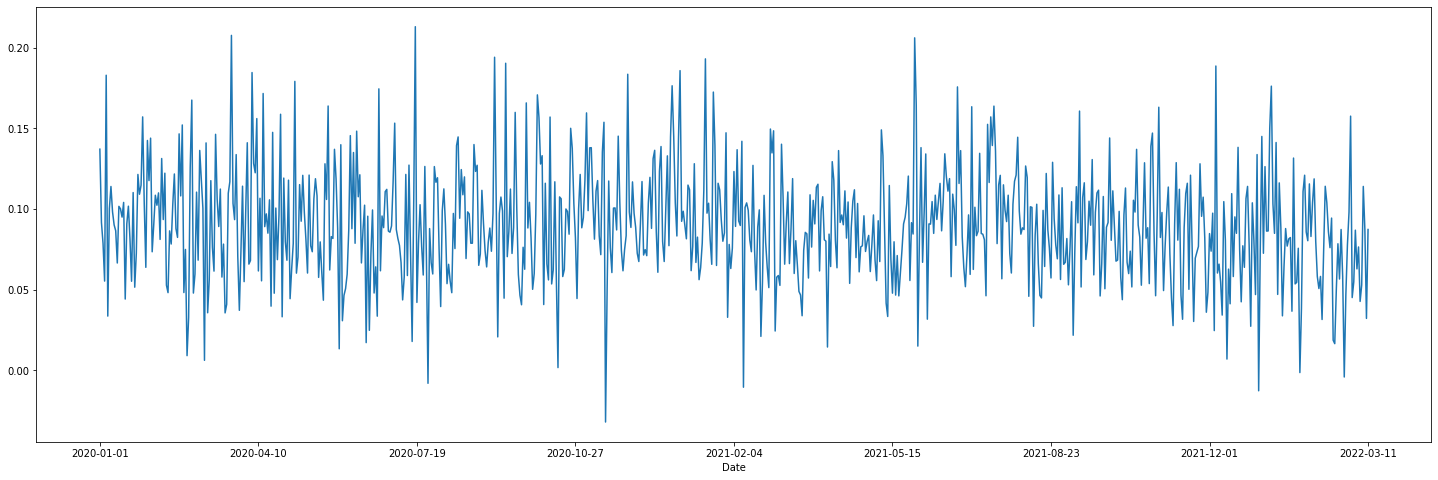

In [ ]:
fig, ax = plt.subplots(figsize=(25, 8)) 
df.groupby('Date')['TextBlob_sentiment_score'].mean().plot()

As you can see, for most of the days sentiment are positive. But we know, stock prices were not constantly moving up. So we can't use this sentiment analysis as it is. We will calculate difference between sentiment score for the days and then will compare it with the stock prices change.

In [ ]:
temp_textBlob_df = df.groupby('Date')['TextBlob_sentiment_score'].mean()
temp_textBlob_df = temp_textBlob_df.to_frame()
temp_textBlob_df.head(7)

,TextBlob_sentiment_score
Date,
2020-01-01,0.14
2020-01-02,0.09
2020-01-03,0.08
2020-01-04,0.06
2020-01-05,0.18
2020-01-06,0.03
2020-01-07,0.10


In [ ]:
temp_textBlob_df = temp_textBlob_df.reset_index()
temp_textBlob_df['Date'] = pd.to_datetime(temp_textBlob_df['Date']).dt.date

#### Group sentiment of weekends with the Monday

In [ ]:
for line_number, (index, row) in enumerate(temp_textBlob_df.iterrows()):
    #print(row['Date'].weekday())  # 0 - Monday, 6- Sunday
    if (row['Date'].weekday() == 5):
        #print(temp_vader_df.loc[index+2,'Vader_comp'])
        temp_textBlob_df.loc[index+2,'TextBlob_sentiment_score'] = (temp_textBlob_df.loc[index,'TextBlob_sentiment_score']+temp_textBlob_df.loc[index+1,'TextBlob_sentiment_score']+temp_textBlob_df.loc[index+2,'TextBlob_sentiment_score'])/3

In [ ]:
temp_textBlob_df.head(7)

,Date,TextBlob_sentiment_score
0,2020-01-01,0.14
1,2020-01-02,0.09
2,2020-01-03,0.08
3,2020-01-04,0.06
4,2020-01-05,0.18
5,2020-01-06,0.09
6,2020-01-07,0.10


#### Merge with stock data

In [ ]:
temp_textBlob_df['Date']= pd.to_datetime(temp_textBlob_df['Date'],format='%Y-%m-%d')

In [ ]:
Text_blob_tesla_df = tesla_df

In [ ]:
Text_blob_tesla_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,Actual_sentiment
2394,2020-01-02,84.90,86.14,84.34,86.05,47660500,0,0.00,NaN,0
2395,2020-01-03,88.10,90.80,87.38,88.60,88892500,0,0.00,2.55,1
2396,2020-01-06,88.09,90.31,88.00,90.31,50665000,0,0.00,1.71,1
2397,2020-01-07,92.28,94.33,90.67,93.81,89410500,0,0.00,3.50,1
2398,2020-01-08,94.74,99.70,93.65,98.43,155721500,0,0.00,4.62,1


In [ ]:
Text_blob_tesla_df['Date']= pd.to_datetime(Text_blob_tesla_df['Date'],format='%Y-%m-%d')
Text_blob_tesla_df = pd.merge(Text_blob_tesla_df, temp_textBlob_df, how='inner', on = 'Date')
Text_blob_tesla_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,Actual_sentiment,TextBlob_sentiment_score
0,2020-01-02,84.90,86.14,84.34,86.05,47660500,0,0.00,NaN,0,0.09
1,2020-01-03,88.10,90.80,87.38,88.60,88892500,0,0.00,2.55,1,0.08
2,2020-01-06,88.09,90.31,88.00,90.31,50665000,0,0.00,1.71,1,0.09
3,2020-01-07,92.28,94.33,90.67,93.81,89410500,0,0.00,3.50,1,0.10
4,2020-01-08,94.74,99.70,93.65,98.43,155721500,0,0.00,4.62,1,0.11


#### Case 1 : Same day sentiment Analysis with difference in sentiment score from previous day

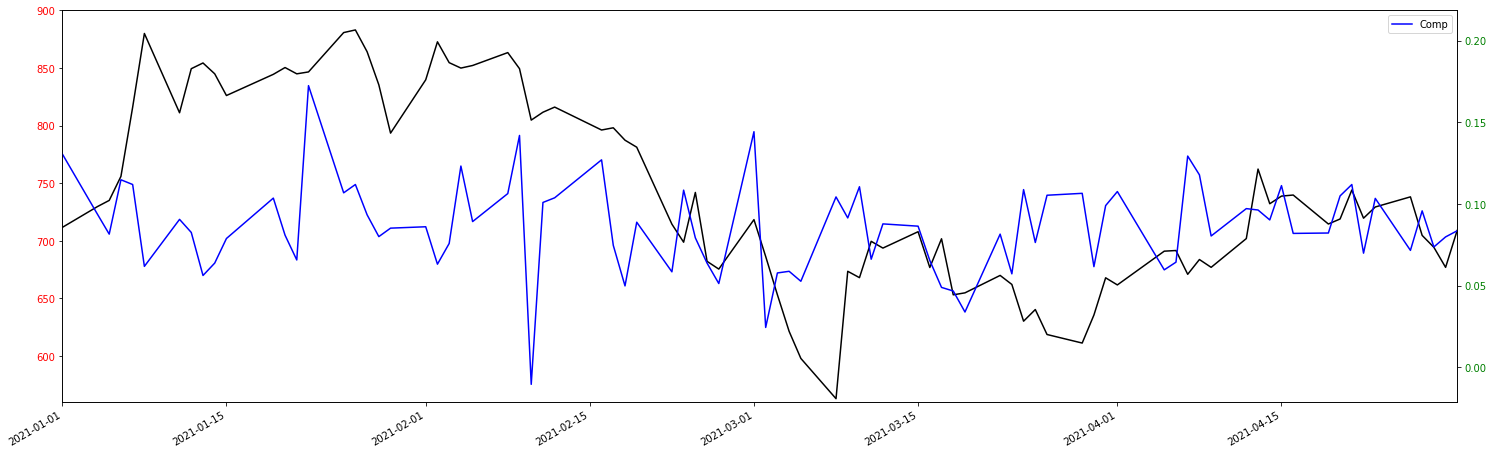

In [ ]:
import datetime as dt
start = dt.datetime(2021,1, 1)
end = dt.datetime(2021,4, 30)
fig, ax = plt.subplots(figsize=(25, 8)) 
ax.plot(Text_blob_tesla_df['Date'],Text_blob_tesla_df['Close'], color='black', label = 'Close Price')
ax.tick_params(axis='y', labelcolor='red')
ax2 = ax.twinx()
ax2.plot(Text_blob_tesla_df['Date'],Text_blob_tesla_df['TextBlob_sentiment_score'], color='blue', label = 'Comp')
ax2.tick_params(axis='y', labelcolor='green')
fig.autofmt_xdate()
ax.set_xlim([start, end])
ax.set_ylim([560, 900])
#ax2.set_ylim([800, 1000])
plt.legend()
plt.show()

In [ ]:
Text_blob_tesla_df['TextBlob_senti_score_change'] = Text_blob_tesla_df['TextBlob_sentiment_score'] - Text_blob_tesla_df.TextBlob_sentiment_score.shift()

In [ ]:
conditions = [
    (Text_blob_tesla_df['TextBlob_senti_score_change'] <= 0.0),
    (Text_blob_tesla_df['TextBlob_senti_score_change'] > 0.0)
    ]
Values =[0,1]
Text_blob_tesla_df['TextBlob_senti_score_change_sentiment'] = np.select(conditions, Values)

In [ ]:
Text_blob_tesla_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,Actual_sentiment,TextBlob_sentiment_score,TextBlob_senti_score_change,TextBlob_senti_score_change_sentiment
0,2020-01-02,84.90,86.14,84.34,86.05,47660500,0,0.00,NaN,0,0.09,NaN,0
1,2020-01-03,88.10,90.80,87.38,88.60,88892500,0,0.00,2.55,1,0.08,-0.01,0
2,2020-01-06,88.09,90.31,88.00,90.31,50665000,0,0.00,1.71,1,0.09,0.01,1
3,2020-01-07,92.28,94.33,90.67,93.81,89410500,0,0.00,3.50,1,0.10,0.01,1
4,2020-01-08,94.74,99.70,93.65,98.43,155721500,0,0.00,4.62,1,0.11,0.01,1


In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(Text_blob_tesla_df['Actual_sentiment'],Text_blob_tesla_df['TextBlob_senti_score_change_sentiment'])

print(cf_matrix)

[[130 121]
 [151 151]]


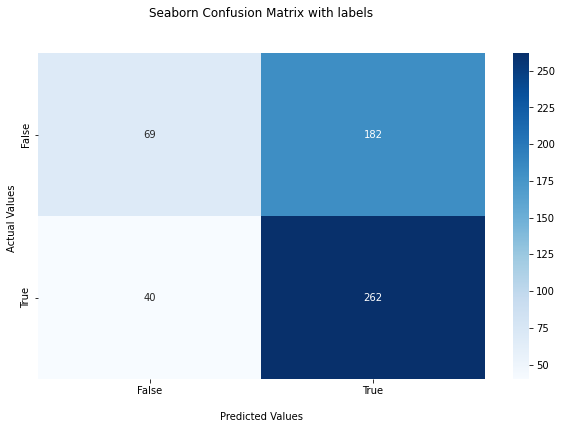

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
pd.set_option('display.float_format', lambda x: '%.6f' % x)

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',  fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.3f' % precision_score(Text_blob_tesla_df['Actual_sentiment'],Text_blob_tesla_df['TextBlob_senti_score_change_sentiment']))
print('Recall: %.3f' % recall_score(Text_blob_tesla_df['Actual_sentiment'],Text_blob_tesla_df['TextBlob_senti_score_change_sentiment']))
print('Accuracy: %.3f' % accuracy_score(Text_blob_tesla_df['Actual_sentiment'],Text_blob_tesla_df['TextBlob_senti_score_change_sentiment']))
print('F1 Score: %.3f' % f1_score(Text_blob_tesla_df['Actual_sentiment'],Text_blob_tesla_df['TextBlob_senti_score_change_sentiment']))

Precision: 0.555
Recall: 0.500
Accuracy: 0.508
F1 Score: 0.526


#### Case 2: Next day sentiment Analysis

In [ ]:
from datetime import datetime, timedelta
temp_textBlob_df['Date'] = pd.to_datetime(temp_textBlob_df['Date']).dt.date
temp_textBlob_df['Date+1'] = temp_textBlob_df['Date'] + timedelta(days = 1 )

In [ ]:
temp_textBlob_df.head()

,Date,TextBlob_sentiment_score,Date+1
0,2020-01-01,0.137056,2020-01-02
1,2020-01-02,0.091698,2020-01-03
2,2020-01-03,0.078728,2020-01-04
3,2020-01-04,0.055364,2020-01-05
4,2020-01-05,0.182859,2020-01-06


In [ ]:
temp_textBlob_df['Date+1']= pd.to_datetime(temp_textBlob_df['Date+1'],format='%Y-%m-%d')
Text_blob_tesla_df = pd.merge(Text_blob_tesla_df, temp_textBlob_df, how='inner', left_on= 'Date',right_on= 'Date+1')

In [ ]:
Text_blob_tesla_df.head()

,Date_x,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,Actual_sentiment,TextBlob_sentiment_score_x,TextBlob_senti_score_change,TextBlob_senti_score_change_sentiment,Date_y,TextBlob_sentiment_score_y,Date+1
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,47660500,0,0.000000,NaN,0,0.091698,NaN,0,2020-01-01,0.137056,2020-01-02
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88892500,0,0.000000,2.549995,1,0.078728,-0.012970,0,2020-01-02,0.091698,2020-01-03
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,50665000,0,0.000000,1.706001,1,0.090634,0.011906,1,2020-01-05,0.182859,2020-01-06
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,89410500,0,0.000000,3.503998,1,0.100244,0.009610,1,2020-01-06,0.090634,2020-01-07
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,155721500,0,0.000000,4.616005,1,0.113946,0.013702,1,2020-01-07,0.100244,2020-01-08


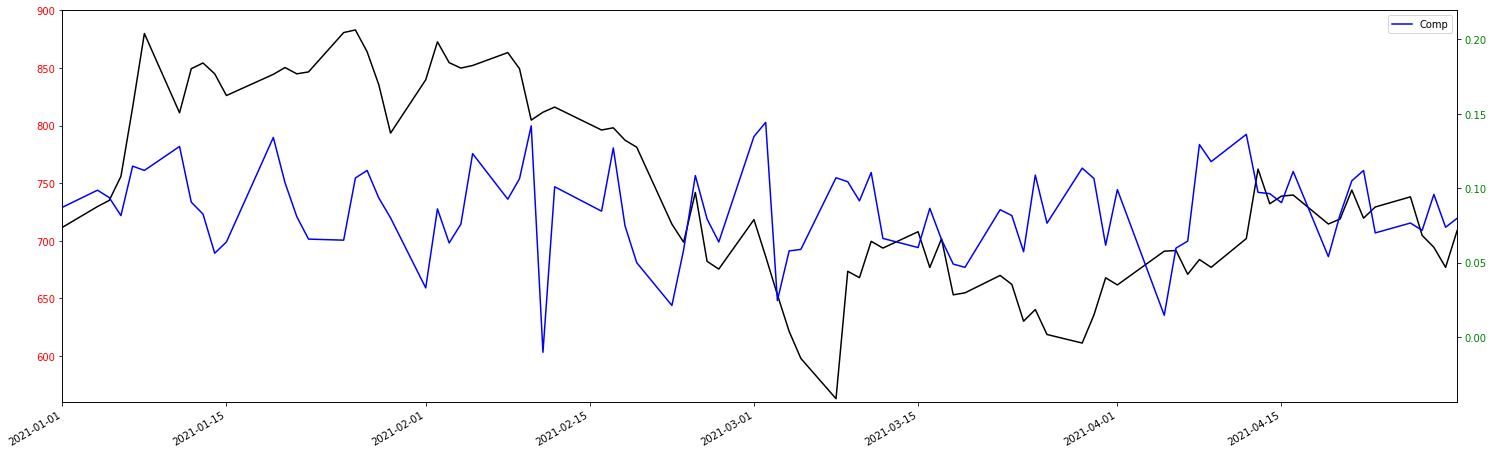

In [ ]:
import datetime as dt
start = dt.datetime(2021,1, 1)
end = dt.datetime(2021,4, 30)
fig, ax = plt.subplots(figsize=(25, 8)) 
ax.plot(Text_blob_tesla_df['Date_x'],Text_blob_tesla_df['Close'], color='black', label = 'Closed Price')
ax.tick_params(axis='y', labelcolor='red')
ax2 = ax.twinx()
ax2.plot(Text_blob_tesla_df['Date_x'],Text_blob_tesla_df['TextBlob_sentiment_score_y'], color='blue', label = 'Comp')
ax2.tick_params(axis='y', labelcolor='green')
fig.autofmt_xdate()
ax.set_xlim([start, end])
ax.set_ylim([560, 900])
plt.legend()
plt.show()

In [ ]:
Text_blob_tesla_df['TextBlob_sentiment_score_y_change'] = Text_blob_tesla_df['TextBlob_sentiment_score_y'] - Text_blob_tesla_df.TextBlob_sentiment_score_y.shift()
conditions = [
    (Text_blob_tesla_df['TextBlob_sentiment_score_y_change'] <= 0.0),
    (Text_blob_tesla_df['TextBlob_sentiment_score_y_change'] > 0.0)
    ]
Values =[0,1]
Text_blob_tesla_df['TextBlob_sentiment_score_y_change'] = np.select(conditions, Values)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.3f' % precision_score(Text_blob_tesla_df['Actual_sentiment'],Text_blob_tesla_df['TextBlob_sentiment_score_y_change']))
print('Recall: %.3f' % recall_score(Text_blob_tesla_df['Actual_sentiment'],Text_blob_tesla_df['TextBlob_sentiment_score_y_change']))
print('Accuracy: %.3f' % accuracy_score(Text_blob_tesla_df['Actual_sentiment'],Text_blob_tesla_df['TextBlob_sentiment_score_y_change']))
print('F1 Score: %.3f' % f1_score(Text_blob_tesla_df['Actual_sentiment'],Text_blob_tesla_df['TextBlob_sentiment_score_y_change']))

Precision: 0.539
Recall: 0.480
Accuracy: 0.492
F1 Score: 0.508


Accuracy got reduce compared with the same day comparision, i.e. most of the sentiment on twitter are realtime and has very less impact on stock price next day. 

### 2. **VADER** (Valence Aware Dictionary for Sentiment Reasoning) -
 VADER is available in NLTK package sensitive to both polarity (positive/negative) and intensity (strength) of emotion. VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.

 For example- Words like ‘love’, ‘enjoy’, ‘happy’, ‘like’ all convey a positive sentiment. Also VADER is intelligent enough to understand the basic context of these words, such as “did not love” as a negative statement. It also understands the emphasis of capitalization and punctuation, such as “ENJOY”

Learn more-  https://www.nltk.org/api/nltk.sentiment.vader.html

Advantages of VADER: 


*   It does not require any training data.
*   It can very well understand the sentiment of a text containing emoticons, slangs, conjunctions, capital words, punctuations and much more.
*   It works excellent on social media text.
*   VADER can work with multiple domains.

SentimentIntensityAnalyzer() is an object and polarity_scores is a method which will  give us scores of the following categories:

Positive
Negative
Neutral
Compound

The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive).

The more Compound score closer to +1, the higher the positivity of the text.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Create function for Vader sentiment analysis
def sentiment_scores(sentence):

# Create a SentimentIntensityAnalyzer object.
    Vad_obj = SentimentIntensityAnalyzer()
    sentiment_dict = Vad_obj.polarity_scores(sentence)
    return(sentiment_dict['pos'],sentiment_dict['neg'],sentiment_dict['neu'],sentiment_dict['compound']) # return score for each sentiment

In [ ]:
df["Vader_senti_score"] = df["clean_text"].apply(sentiment_scores)

In [ ]:
df.head()

,Date,Text,User,Retweet_count,Verified,clean_text,TextBlob_sentiment_score,Vader_senti_score
120,2022-01-01,@coL_Fantasy @HuNteR_Jjx @saraharidgeway @Comp...,thyAshes,0,True,tri get rid sir,0.000000,"(0.0, 0.0, 1.0, 0.0)"
145,2022-01-01,"Reflecting on 2021, I had a pretty great year....",thyAshes,0,True,reflect pretti great year marri best friend ...,0.600000,"(0.494, 0.0, 0.506, 0.9661)"
152,2022-01-01,Benzinga Bulls And Bears Of The Past Week: Dis...,Benzinga,9,True,benzinga bull bear past week disney ford carni...,-0.250000,"(0.0, 0.0, 1.0, 0.0)"
178,2022-01-01,The Model Y is the second @Tesla to score an @...,CARandDRIVER,7,True,model second score top safeti pick award,0.250000,"(0.515, 0.0, 0.485, 0.6486)"
219,2022-01-01,@rodmacpherson @Tesla And I'm not alone. 70% o...,tommolog,0,True,im alon respond think theyll deliv year,0.000000,"(0.0, 0.0, 1.0, 0.0)"


In [ ]:
df[['Vader_pos','Vader_neg','Vader_neu','Vader_comp']] = pd.DataFrame(df.Vader_senti_score.tolist(), index= df.index)

In [ ]:
df.head()

,Date,Text,User,Retweet_count,Verified,clean_text,TextBlob_sentiment_score,Vader_senti_score,Vader_pos,Vader_neg,Vader_neu,Vader_comp
120,2022-01-01,@coL_Fantasy @HuNteR_Jjx @saraharidgeway @Comp...,thyAshes,0,True,tri get rid sir,0.000000,"(0.0, 0.0, 1.0, 0.0)",0.000000,0.000000,1.000000,0.000000
145,2022-01-01,"Reflecting on 2021, I had a pretty great year....",thyAshes,0,True,reflect pretti great year marri best friend ...,0.600000,"(0.494, 0.0, 0.506, 0.9661)",0.494000,0.000000,0.506000,0.966100
152,2022-01-01,Benzinga Bulls And Bears Of The Past Week: Dis...,Benzinga,9,True,benzinga bull bear past week disney ford carni...,-0.250000,"(0.0, 0.0, 1.0, 0.0)",0.000000,0.000000,1.000000,0.000000
178,2022-01-01,The Model Y is the second @Tesla to score an @...,CARandDRIVER,7,True,model second score top safeti pick award,0.250000,"(0.515, 0.0, 0.485, 0.6486)",0.515000,0.000000,0.485000,0.648600
219,2022-01-01,@rodmacpherson @Tesla And I'm not alone. 70% o...,tommolog,0,True,im alon respond think theyll deliv year,0.000000,"(0.0, 0.0, 1.0, 0.0)",0.000000,0.000000,1.000000,0.000000


Now, we need to calculate sentiment value at the daily level. We will aggerigate compound sentiment values at daily level and consider it as a sentiment for the day.

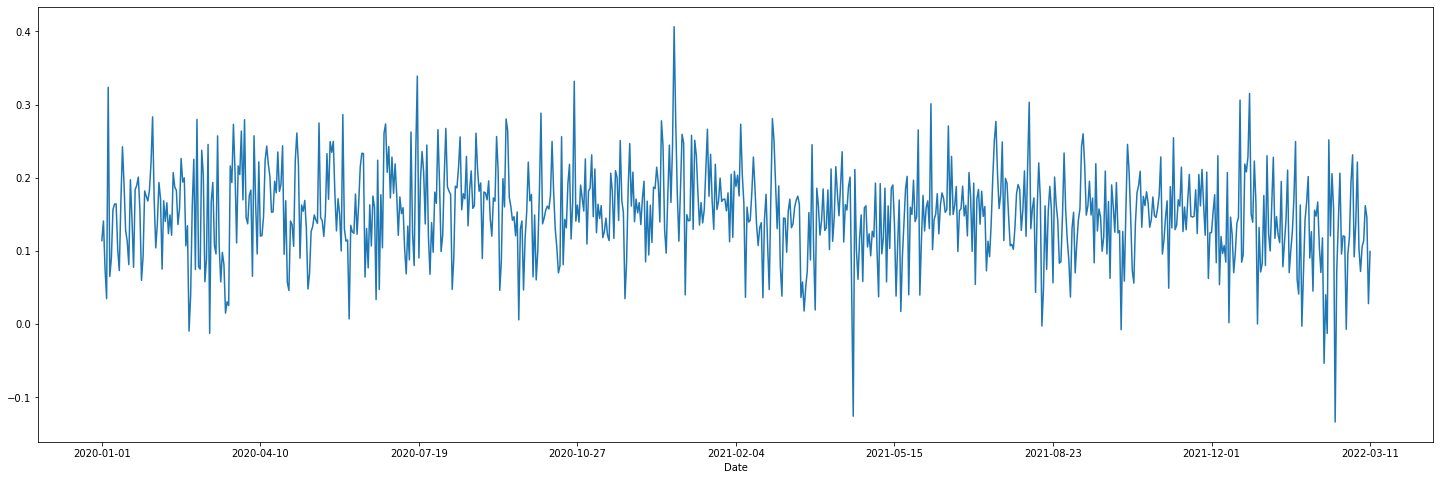

In [ ]:
fig, ax = plt.subplots(figsize=(25, 8)) 
df.groupby('Date')['Vader_comp'].mean().plot()

From above graph, we can see that for most of the day, we have neutral sentiment. We can compare this sentiment score with the stock change and see how much accuracy we are getting.

In [ ]:
temp_vader_df = df.groupby('Date')['Vader_comp'].mean()

In [ ]:
temp_vader_df = temp_vader_df.to_frame()

In [ ]:
temp_vader_df.head(7)

,Vader_comp
Date,
2020-01-01,0.114251
2020-01-02,0.140955
2020-01-03,0.075999
2020-01-04,0.034979
2020-01-05,0.323600
2020-01-06,0.065247
2020-01-07,0.090152


for comparision we will need binary values 1 for positve sentiment and 0 for negative sentiment.

In [ ]:
temp_vader_df = temp_vader_df.reset_index()

In [ ]:
temp_vader_df['Date'] = pd.to_datetime(temp_vader_df['Date']).dt.date

Group sentiment of weekend (Saturday and Sunday) to Monday 

In [ ]:
for line_number, (index, row) in enumerate(temp_vader_df.iterrows()):
    #print(row['Date'].weekday())  # 0 - Monday, 6- Sunday
    if (row['Date'].weekday() == 5):
        #print(temp_vader_df.loc[index+2,'Vader_comp'])
        temp_vader_df.loc[index+2,'Vader_comp'] = (temp_vader_df.loc[index,'Vader_comp']+temp_vader_df.loc[index+1,'Vader_comp']+temp_vader_df.loc[index+2,'Vader_comp'])/3

In [ ]:
temp_vader_df.head(7)

,Date,Vader_comp
0,2020-01-01,0.114251
1,2020-01-02,0.140955
2,2020-01-03,0.075999
3,2020-01-04,0.034979
4,2020-01-05,0.323600
5,2020-01-06,0.141275
6,2020-01-07,0.090152


In [ ]:
conditions = [
    (temp_vader_df['Vader_comp'] <= 0.0),
    (temp_vader_df['Vader_comp'] > 0.0)
    ]
Values =[0,1]

In [ ]:
temp_vader_df['Vader_sentiment'] = np.select(conditions, Values)

In [ ]:
temp_vader_df.head()

,Date,Vader_comp,Vader_sentiment
0,2020-01-01,0.114251,1
1,2020-01-02,0.140955,1
2,2020-01-03,0.075999,1
3,2020-01-04,0.034979,1
4,2020-01-05,0.323600,1


Now, join this dataframe with the tesla_df and let's see how much we are able to predict the market sentiment with the help of tweets and Vedar sentiment analyzer

In [ ]:
temp_vader_df['Date']= pd.to_datetime(temp_vader_df['Date'],format='%Y-%m-%d')

In [ ]:
vader_tesla_df = tesla_df

In [ ]:
vader_tesla_df['Date']= pd.to_datetime(vader_tesla_df['Date'],format='%Y-%m-%d')

In [ ]:
vader_tesla_df = pd.merge(vader_tesla_df, temp_vader_df, how='inner', on = 'Date')

In [ ]:
vader_tesla_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,Actual_sentiment,Vader_comp,Vader_sentiment
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,47660500,0,0.000000,NaN,0,0.140955,1
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88892500,0,0.000000,2.549995,1,0.075999,1
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,50665000,0,0.000000,1.706001,1,0.141275,1
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,89410500,0,0.000000,3.503998,1,0.090152,1
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,155721500,0,0.000000,4.616005,1,0.156584,1


Now, let's see how much accuracy we are able to achieve with Vader sentiment analyzer. let's design confusion matrix for the same. 

#### Case 1 : Same day sentiment Analysis

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_sentiment'])

print(cf_matrix)

[[  5 246]
 [  1 301]]


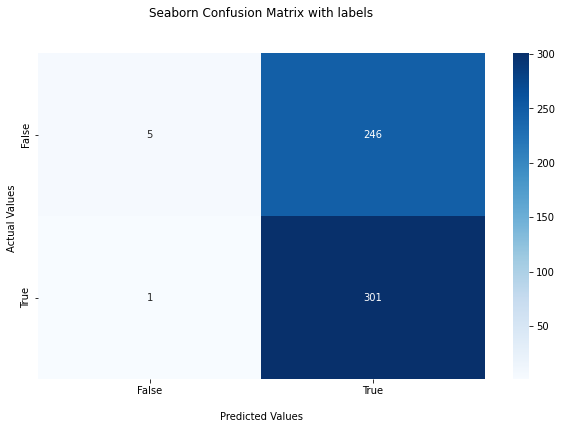

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.3f' % precision_score(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_sentiment']))
print('Recall: %.3f' % recall_score(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_sentiment']))
print('Accuracy: %.3f' % accuracy_score(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_sentiment']))
print('F1 Score: %.3f' % f1_score(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_sentiment']))

Precision: 0.550
Recall: 0.997
Accuracy: 0.553
F1 Score: 0.709


This looks different than what we expected. In long term people are positive about the overall Tesla stock and hence it raised from \$200 to \$1200 in short term and our sentiment analysis is also predicting the same. But, now how should we predict influence of daily sentiment level on stock. Let's , first visualize our results and see what we can do further  

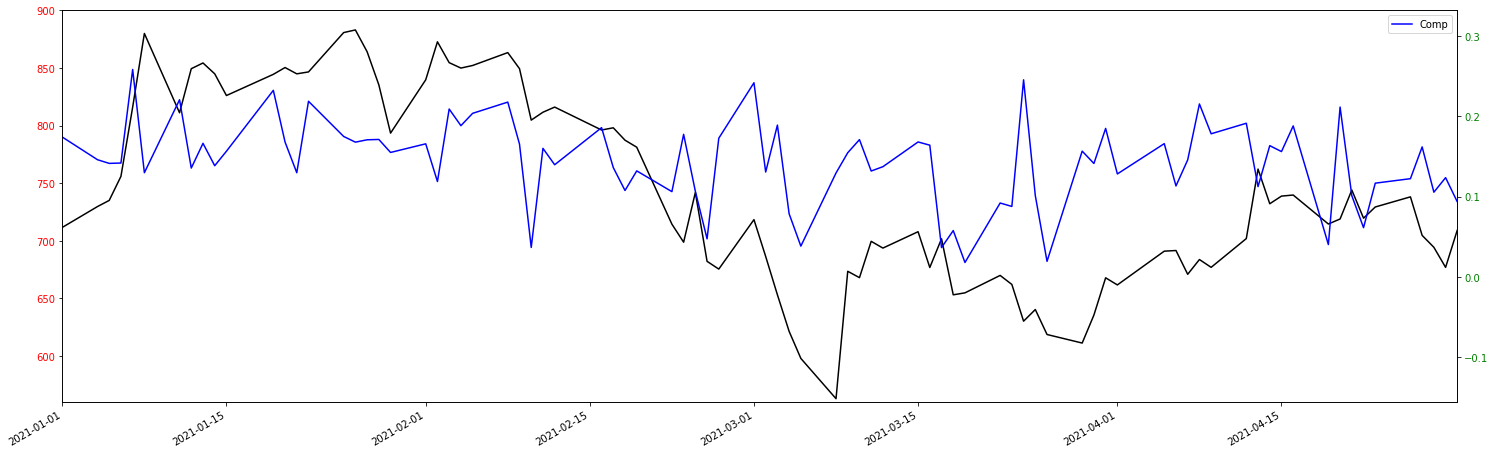

In [ ]:
import datetime as dt
start = dt.datetime(2021,1, 1)
end = dt.datetime(2021,4, 30)
fig, ax = plt.subplots(figsize=(25, 8)) 
ax.plot(vader_tesla_df['Date'],vader_tesla_df['Close'], color='black', label = 'Closed Price')
ax.tick_params(axis='y', labelcolor='red')
ax2 = ax.twinx()
ax2.plot(vader_tesla_df['Date'],vader_tesla_df['Vader_comp'], color='blue', label = 'Comp')
ax2.tick_params(axis='y', labelcolor='green')
fig.autofmt_xdate()
ax.set_xlim([start, end])
ax.set_ylim([560, 900])
plt.legend()
plt.show()

From above graph, we cam see that our sentiment graph is following same pattern but, if we just convert sentiment values greater than 0 to positive sentiment and less than 0 to negative sentiment, would not be correct. Hemce, let's calculate differnce betweet sentiment score for current day and previous day and then analyse further

#### Case 2 : Same day sentiment Analysis with difference in sentiment score from previous day

In [ ]:
vader_tesla_df['Vader_comp_change'] = vader_tesla_df['Vader_comp'] - vader_tesla_df.Vader_comp.shift()

In [ ]:
conditions = [
    (vader_tesla_df['Vader_comp_change'] <= 0.0),
    (vader_tesla_df['Vader_comp_change'] > 0.0)
    ]
Values =[0,1]
vader_tesla_df['Vader_comp_change'] = np.select(conditions, Values)

In [ ]:
vader_tesla_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,Actual_sentiment,Vader_comp,Vader_sentiment,Vader_comp_change
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,47660500,0,0.000000,NaN,0,0.140955,1,0
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88892500,0,0.000000,2.549995,1,0.075999,1,0
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,50665000,0,0.000000,1.706001,1,0.141275,1,1
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,89410500,0,0.000000,3.503998,1,0.090152,1,0
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,155721500,0,0.000000,4.616005,1,0.156584,1,1


In [ ]:
cf_matrix = confusion_matrix(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_comp_change'])

print(cf_matrix)

[[140 111]
 [137 165]]


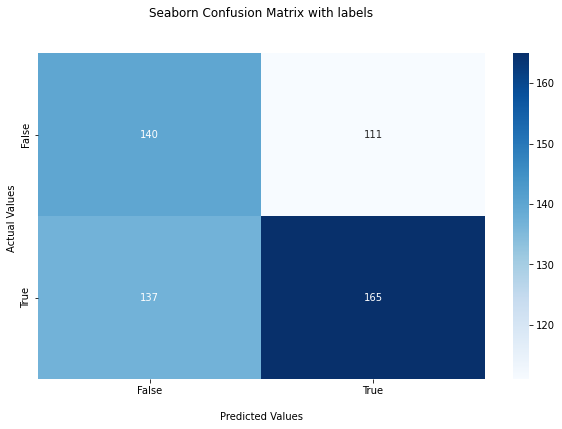

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.3f' % precision_score(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_comp_change']))
print('Recall: %.3f' % recall_score(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_comp_change']))
print('Accuracy: %.3f' % accuracy_score(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_comp_change']))
print('F1 Score: %.3f' % f1_score(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_comp_change']))

Precision: 0.598
Recall: 0.546
Accuracy: 0.552
F1 Score: 0.571


Though twitter is realtime, we know news effect can also take place next day on the market. let's see what happens if we move twitter sentiment by 1 day.

#### Case 3 : Next day sentiment Analysis

In [ ]:
from datetime import datetime, timedelta
temp_vader_df['Date'] = pd.to_datetime(temp_vader_df['Date']).dt.date
temp_vader_df['Date+1'] = temp_vader_df['Date'] + timedelta(days = 1 )

In [ ]:
temp_vader_df.head()

,Date,Vader_comp,Vader_sentiment,Date+1
0,2020-01-01,0.114251,1,2020-01-02
1,2020-01-02,0.140955,1,2020-01-03
2,2020-01-03,0.075999,1,2020-01-04
3,2020-01-04,0.034979,1,2020-01-05
4,2020-01-05,0.323600,1,2020-01-06


In [ ]:
temp_vader_df['Date+1']= pd.to_datetime(temp_vader_df['Date+1'],format='%Y-%m-%d')
vader_tesla_df = pd.merge(vader_tesla_df, temp_vader_df, how='inner', left_on= 'Date',right_on= 'Date+1')

In [ ]:
vader_tesla_df.head()

,Date_x,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,Actual_sentiment,Vader_comp_x,Vader_sentiment_x,Vader_comp_change,Date_y,Vader_comp_y,Vader_sentiment_y,Date+1
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,47660500,0,0.000000,NaN,0,0.140955,1,0,2020-01-01,0.114251,1,2020-01-02
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88892500,0,0.000000,2.549995,1,0.075999,1,0,2020-01-02,0.140955,1,2020-01-03
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,50665000,0,0.000000,1.706001,1,0.141275,1,1,2020-01-05,0.323600,1,2020-01-06
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,89410500,0,0.000000,3.503998,1,0.090152,1,0,2020-01-06,0.141275,1,2020-01-07
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,155721500,0,0.000000,4.616005,1,0.156584,1,1,2020-01-07,0.090152,1,2020-01-08


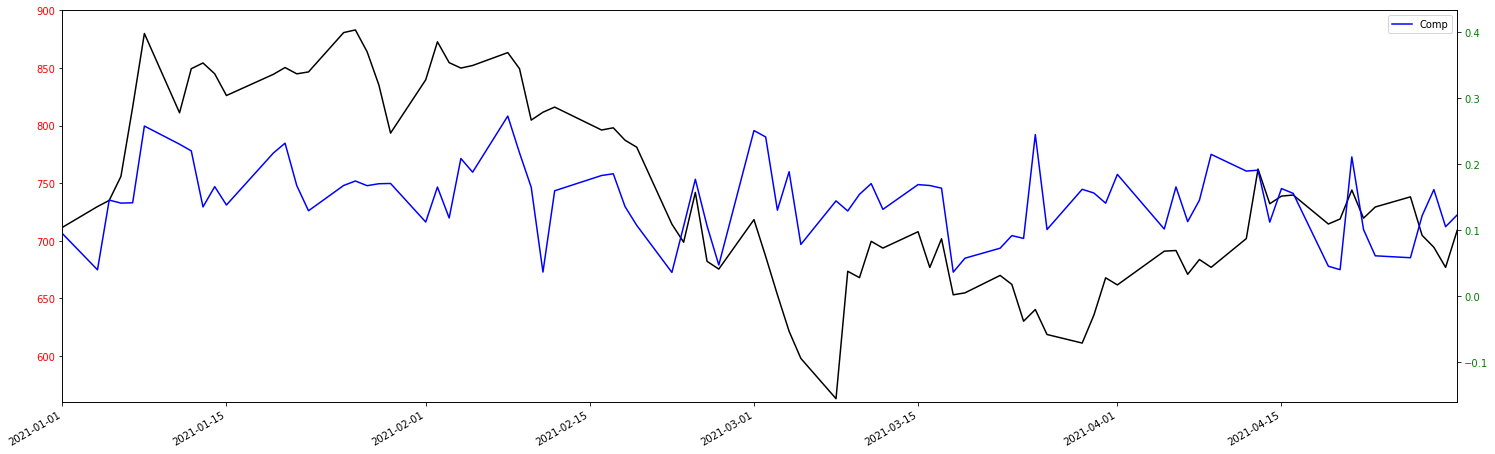

In [ ]:
import datetime as dt
start = dt.datetime(2021,1, 1)
end = dt.datetime(2021,4, 30)
fig, ax = plt.subplots(figsize=(25, 8)) 
ax.plot(vader_tesla_df['Date_x'],vader_tesla_df['Close'], color='black', label = 'Closed Price')
ax.tick_params(axis='y', labelcolor='red')
ax2 = ax.twinx()
ax2.plot(vader_tesla_df['Date_x'],vader_tesla_df['Vader_comp_y'], color='blue', label = 'Comp')
ax2.tick_params(axis='y', labelcolor='green')
fig.autofmt_xdate()
ax.set_xlim([start, end])
ax.set_ylim([560, 900])
plt.legend()
plt.show()

In [ ]:
vader_tesla_df['Vader_comp_y_change'] = vader_tesla_df['Vader_comp_y'] - vader_tesla_df.Vader_comp_y.shift()
conditions = [
    (vader_tesla_df['Vader_comp_y_change'] <= 0.0),
    (vader_tesla_df['Vader_comp_y_change'] > 0.0)
    ]
Values =[0,1]
vader_tesla_df['Vader_comp_y_change'] = np.select(conditions, Values)

In [ ]:
vader_tesla_df.head()

,Date_x,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,Actual_sentiment,Vader_comp_x,Vader_sentiment_x,Vader_comp_change,Date_y,Vader_comp_y,Vader_sentiment_y,Date+1,Vader_comp_y_change
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,47660500,0,0.000000,NaN,0,0.140955,1,0,2020-01-01,0.114251,1,2020-01-02,0
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88892500,0,0.000000,2.549995,1,0.075999,1,0,2020-01-02,0.140955,1,2020-01-03,1
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,50665000,0,0.000000,1.706001,1,0.141275,1,1,2020-01-05,0.323600,1,2020-01-06,1
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,89410500,0,0.000000,3.503998,1,0.090152,1,0,2020-01-06,0.141275,1,2020-01-07,0
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,155721500,0,0.000000,4.616005,1,0.156584,1,1,2020-01-07,0.090152,1,2020-01-08,0


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.3f' % precision_score(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_comp_y_change']))
print('Recall: %.3f' % recall_score(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_comp_y_change']))
print('Accuracy: %.3f' % accuracy_score(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_comp_y_change']))
print('F1 Score: %.3f' % f1_score(vader_tesla_df['Actual_sentiment'],vader_tesla_df['Vader_comp_y_change']))

Precision: 0.538
Recall: 0.467
Accuracy: 0.490
F1 Score: 0.500


In this case, our accuracy got reduced. i.e. the intial claim we made tweets might have effect on stock price next day is failed, hence, we can conclude that tweets have realtime effect on market.

### 3. **Roberta**


Twitter-roBERTa-base for Sentiment Analysis
This is a roBERTa-base model trained on ~125M tweets and finetuned for sentiment analysis with the TweetEval benchmark. This model is suitable for English 

Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive



Learn More- https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment

In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
df =df.drop(['Vader_senti_score', 'Vader_pos','Vader_neg','Vader_neu'], axis =1)

In [ ]:
df.head()

,Date,Text,User,Retweet_count,Verified,clean_text,TextBlob_sentiment_score,Vader_comp
44,2021-05-05,@KTX_games @BLU3ZIGZAG @elonmusk @Tesla These ...,Erdayastronaut,0,True,still nitrogen thruster wouldn't fire hot ...,0.21,-0.10
51,2021-05-05,@ricardospx1 @elonmusk @Tesla Those are in the...,Erdayastronaut,1,True,middl rocket could header tank depress mayb...,0.05,-0.18
60,2021-05-05,Thank you all.\n\n#stocks #stockguru #tesla #n...,Jamyies,2,True,thank allstock stockguru tesla nio palantir do...,0.00,0.36
88,2021-05-05,.@Stellantis spent about $2.40 billion to buy ...,HTAutotweets,0,True,spent billion buy european us credit period,-0.05,0.38
121,2021-05-05,"So how is @tesla worth $648B in market cap, wh...",teedubya,4,True,worth market cap quarter largest ever oper ...,0.30,0.59


In [ ]:
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)
labels = ['Negative', 'Neutral', 'Positive']

def roberta_fun(text):
    output = model(**(tokenizer(text, return_tensors='pt')))
    scores = softmax(output[0][0].detach().numpy())
    
    return scores

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
df["roberta_analysis"] = df["clean_text"].apply(roberta_fun)
df

,Date,Text,User,Retweet_count,Verified,clean_text,Vader_comp,roberta_analysis
44,2021-05-05,@KTX_games @BLU3ZIGZAG @elonmusk @Tesla These ...,Erdayastronaut,0,True,still nitrogen thruster wouldn't fire hot ...,-0.10,"[0.41523984, 0.55163723, 0.033122905]"
51,2021-05-05,@ricardospx1 @elonmusk @Tesla Those are in the...,Erdayastronaut,1,True,middl rocket could header tank depress mayb...,-0.18,"[0.12642375, 0.8114955, 0.06208072]"
60,2021-05-05,Thank you all.\n\n#stocks #stockguru #tesla #n...,Jamyies,2,True,thank allstock stockguru tesla nio palantir do...,0.36,"[0.011570542, 0.5136274, 0.4748021]"
88,2021-05-05,.@Stellantis spent about $2.40 billion to buy ...,HTAutotweets,0,True,spent billion buy european us credit period,0.38,"[0.16945352, 0.744758, 0.08578845]"
121,2021-05-05,"So how is @tesla worth $648B in market cap, wh...",teedubya,4,True,worth market cap quarter largest ever oper ...,0.59,"[0.009062273, 0.44965377, 0.54128397]"
...,...,...,...,...,...,...,...,...
3992199,2021-05-05,"Oooops, there go the $tsla profits https://t.c...",BertelSchmitt,6,True,oooop go tsla profit,0.44,"[0.20062093, 0.6805644, 0.11881468]"
3992203,2021-05-05,@Frontal21 @ZDF @ZDFheute @lk_lueneburg @NABU_...,BertelSchmitt,0,True,note tsla german picki water,0.00,"[0.14565684, 0.81228685, 0.04205628]"
3992233,2021-05-05,Authorities open labour probe at German $TSLA ...,BertelSchmitt,0,True,author open labour probe german tsla site bus...,0.00,"[0.09596557, 0.8721941, 0.031840395]"
3992293,2021-05-05,It’s easy to do ultra fast charging by this ne...,hohocho,0,True,it easi ultra fast charg new supercharg chun...,0.44,"[0.0037952675, 0.21480958, 0.78139514]"


In [ ]:
df_roberta = pd.read_csv('verified_data_roberta.csv')

In [ ]:
df_roberta.head()

,Date,Text,Retweet_count,analysis,Negative,Neutral,Positive
0,1/1/22,@coL_Fantasy @HuNteR_Jjx @saraharidgeway @Comp...,0,[0.44651234 0.5254265 0.02806125],0.45,0.53,0.03
1,1/1/22,"Reflecting on 2021, I had a pretty great year....",0,[0.00384871 0.05837418 0.9377773 ],0.00,0.06,0.94
2,1/1/22,Benzinga Bulls And Bears Of The Past Week: Dis...,9,[0.05545839 0.8558184 0.08872328],0.06,0.86,0.09
3,1/1/22,The Model Y is the second @Tesla to score an @...,7,[0.03414343 0.6974675 0.26838908],0.03,0.70,0.27
4,1/1/22,@rodmacpherson @Tesla And I'm not alone. 70% o...,0,[0.08614679 0.8129632 0.10088986],0.09,0.81,0.10


In [ ]:
df_roberta['Date'] = pd.to_datetime(df_roberta['Date']).dt.date

In [ ]:
df_roberta.head()

,Date,Text,Retweet_count,analysis,Negative,Neutral,Positive
0,2022-01-01,@coL_Fantasy @HuNteR_Jjx @saraharidgeway @Comp...,0,[0.44651234 0.5254265 0.02806125],0.45,0.53,0.03
1,2022-01-01,"Reflecting on 2021, I had a pretty great year....",0,[0.00384871 0.05837418 0.9377773 ],0.00,0.06,0.94
2,2022-01-01,Benzinga Bulls And Bears Of The Past Week: Dis...,9,[0.05545839 0.8558184 0.08872328],0.06,0.86,0.09
3,2022-01-01,The Model Y is the second @Tesla to score an @...,7,[0.03414343 0.6974675 0.26838908],0.03,0.70,0.27
4,2022-01-01,@rodmacpherson @Tesla And I'm not alone. 70% o...,0,[0.08614679 0.8129632 0.10088986],0.09,0.81,0.10


In [ ]:
temp_roberta_df = df_roberta.groupby('Date')['Negative','Positive'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
temp_roberta_df.head()

,Negative,Positive
Date,,
2020-01-01,0.19,0.21
2020-01-02,0.12,0.24
2020-01-03,0.15,0.20
2020-01-04,0.19,0.17
2020-01-05,0.12,0.36


Group sentiment of weekend.

In [ ]:
temp_roberta_df = temp_roberta_df.reset_index()

In [ ]:
for line_number, (index, row) in enumerate(temp_roberta_df.iterrows()):
    #print(row['Date'].weekday())  # 0 - Monday, 6- Sunday
    if (row['Date'].weekday() == 5):
        #print(temp_vader_df.loc[index+2,'Vader_comp'])
        temp_roberta_df.loc[index+2,'Negative'] = (temp_roberta_df.loc[index,'Negative']+temp_roberta_df.loc[index+1,'Negative']+temp_roberta_df.loc[index+2,'Negative'])/3
        temp_roberta_df.loc[index+2,'Positive'] = (temp_roberta_df.loc[index,'Positive']+temp_roberta_df.loc[index+1,'Positive']+temp_roberta_df.loc[index+2,'Positive'])/3

In [ ]:
temp_roberta_df['roberta_sentiment_values'] = temp_roberta_df['Positive'] - temp_roberta_df['Negative']

In [ ]:
conditions = [
    (temp_roberta_df['roberta_sentiment_values'] <= 0.0),
    (temp_roberta_df['roberta_sentiment_values'] > 0.0)
    ]
Values =[0,1]
temp_roberta_df['roberta_sentiment'] = np.select(conditions, Values)

In [ ]:
temp_roberta_df.head()

,Date,Negative,Positive,roberta_sentiment_values,roberta_sentiment
0,2020-01-01,0.19,0.21,0.02,1
1,2020-01-02,0.12,0.24,0.12,1
2,2020-01-03,0.15,0.20,0.04,1
3,2020-01-04,0.19,0.17,-0.02,0
4,2020-01-05,0.12,0.36,0.24,1


#### Case 1 : Same day sentiment Analysis

In [ ]:
roberta_tesla_df = tesla_df

In [ ]:
temp_roberta_df['Date']= pd.to_datetime(temp_roberta_df['Date'],format='%Y-%m-%d')

In [ ]:
roberta_tesla_df['Date']= pd.to_datetime(roberta_tesla_df['Date'],format='%Y-%m-%d')

In [ ]:
roberta_tesla_df = pd.merge(roberta_tesla_df, temp_roberta_df, how='inner', on = 'Date')

In [ ]:
roberta_tesla_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,Actual_sentiment,Negative,Positive,roberta_sentiment_values,roberta_sentiment
0,2020-01-02,84.90,86.14,84.34,86.05,47660500,0,0.00,NaN,0,0.12,0.24,0.12,1
1,2020-01-03,88.10,90.80,87.38,88.60,88892500,0,0.00,2.55,1,0.15,0.20,0.04,1
2,2020-01-06,88.09,90.31,88.00,90.31,50665000,0,0.00,1.71,1,0.17,0.24,0.07,1
3,2020-01-07,92.28,94.33,90.67,93.81,89410500,0,0.00,3.50,1,0.12,0.17,0.05,1
4,2020-01-08,94.74,99.70,93.65,98.43,155721500,0,0.00,4.62,1,0.16,0.21,0.05,1


In [ ]:
cf_matrix = confusion_matrix(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['roberta_sentiment'])

print(cf_matrix)

[[ 69 182]
 [ 40 262]]


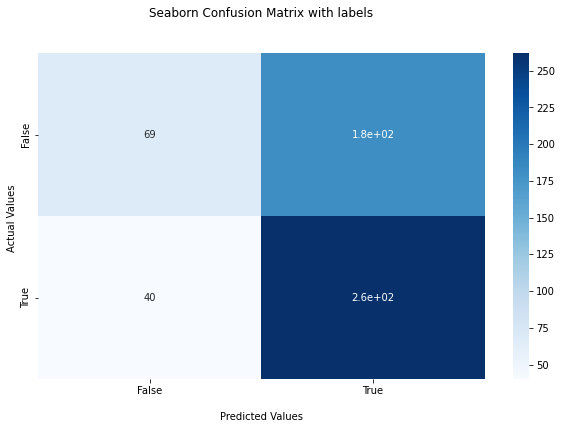

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.3f' % precision_score(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['roberta_sentiment']))
print('Recall: %.3f' % recall_score(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['roberta_sentiment']))
print('Accuracy: %.3f' % accuracy_score(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['roberta_sentiment']))
print('F1 Score: %.3f' % f1_score(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['roberta_sentiment']))

Precision: 0.590
Recall: 0.868
Accuracy: 0.599
F1 Score: 0.702


#### Case 2 : Same day sentiment Analysis with difference in sentiment score from previous day

In [ ]:
roberta_tesla_df['Roberta_senti_change'] = roberta_tesla_df['roberta_sentiment_values'] - roberta_tesla_df.roberta_sentiment_values.shift()

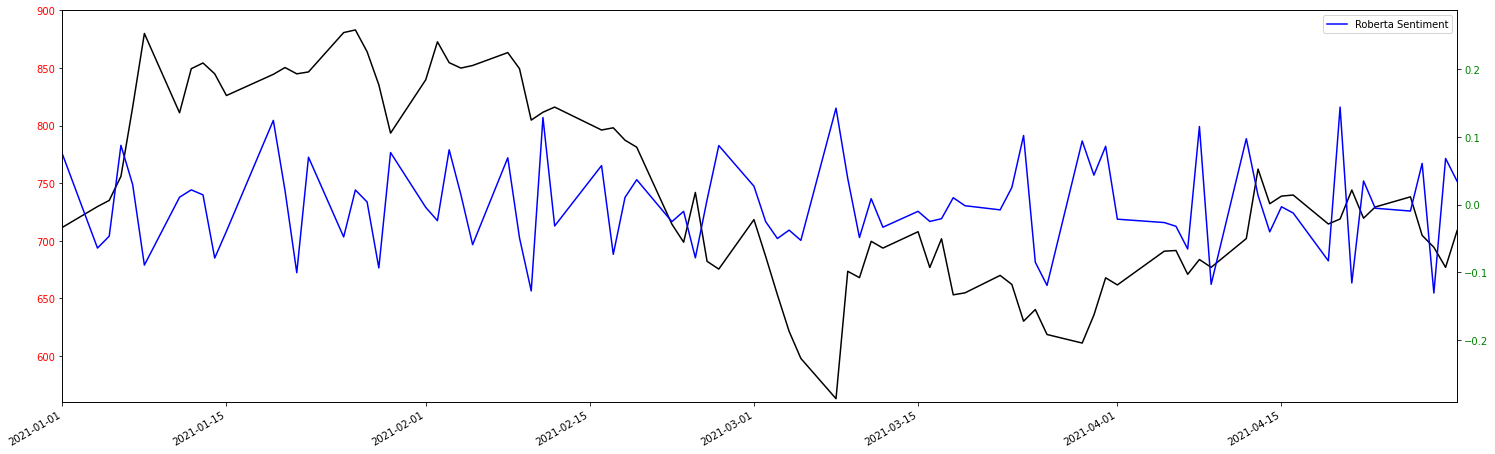

In [ ]:
import datetime as dt
start = dt.datetime(2021,1, 1)
end = dt.datetime(2021,4, 30)
fig, ax = plt.subplots(figsize=(25, 8)) 
ax.plot(roberta_tesla_df['Date'],roberta_tesla_df['Close'], color='black', label = 'Close Price')
ax.tick_params(axis='y', labelcolor='red')
ax2 = ax.twinx()
ax2.plot(roberta_tesla_df['Date'],roberta_tesla_df['Roberta_senti_change'], color='blue', label = 'Roberta Sentiment')
ax2.tick_params(axis='y', labelcolor='green')
fig.autofmt_xdate()
ax.set_xlim([start, end])
ax.set_ylim([560, 900])
plt.legend()
plt.show()

In [ ]:
conditions = [
    (roberta_tesla_df['Roberta_senti_change'] <= 0.0),
    (roberta_tesla_df['Roberta_senti_change'] > 0.0)
    ]
Values =[0,1]
roberta_tesla_df['Roberta_senti_change'] = np.select(conditions, Values)

In [ ]:
cf_matrix = confusion_matrix(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['Roberta_senti_change'])

print(cf_matrix)

[[151 100]
 [135 167]]


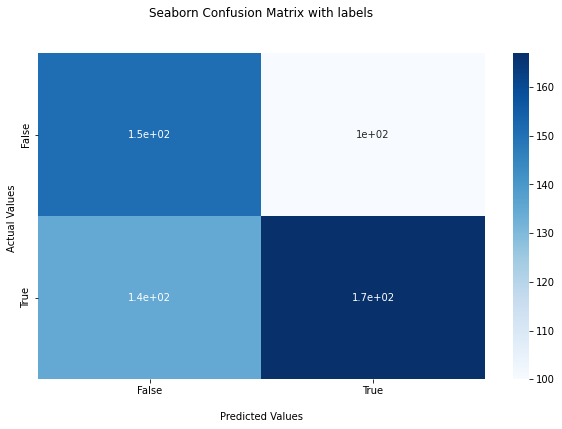

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.3f' % precision_score(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['Roberta_senti_change']))
print('Recall: %.3f' % recall_score(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['Roberta_senti_change']))
print('Accuracy: %.3f' % accuracy_score(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['Roberta_senti_change']))
print('F1 Score: %.3f' % f1_score(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['Roberta_senti_change']))

Precision: 0.625
Recall: 0.553
Accuracy: 0.575
F1 Score: 0.587


#### Case 3 : Next day sentiment Analysis

In [ ]:
from datetime import datetime, timedelta
temp_roberta_df['Date'] = pd.to_datetime(temp_vader_df['Date']).dt.date
temp_roberta_df['Date+1'] = temp_roberta_df['Date'] + timedelta(days = 1 )

In [ ]:
temp_roberta_df.head()

,Date,Negative,Positive,roberta_sentiment,roberta_sentiment_values,Date+1
0,2020-01-01,0.19,0.21,1,0.02,2020-01-02
1,2020-01-02,0.12,0.24,1,0.12,2020-01-03
2,2020-01-03,0.15,0.20,1,0.04,2020-01-04
3,2020-01-04,0.19,0.17,0,-0.02,2020-01-05
4,2020-01-05,0.12,0.36,1,0.24,2020-01-06


In [ ]:
roberta_tesla_df =tesla_df

In [ ]:
temp_roberta_df['Date+1']= pd.to_datetime(temp_roberta_df['Date+1'],format='%Y-%m-%d')
roberta_tesla_df = pd.merge(roberta_tesla_df, temp_roberta_df, how='inner', left_on= 'Date',right_on= 'Date+1')

In [ ]:
roberta_tesla_df.head()

,Date_x,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,Actual_sentiment,Date_y,Negative,Positive,roberta_sentiment,roberta_sentiment_values,Date+1
0,2020-01-02,84.90,86.14,84.34,86.05,47660500,0,0.00,NaN,0,2020-01-01,0.19,0.21,1,0.02,2020-01-02
1,2020-01-03,88.10,90.80,87.38,88.60,88892500,0,0.00,2.55,1,2020-01-02,0.12,0.24,1,0.12,2020-01-03
2,2020-01-06,88.09,90.31,88.00,90.31,50665000,0,0.00,1.71,1,2020-01-05,0.12,0.36,1,0.24,2020-01-06
3,2020-01-07,92.28,94.33,90.67,93.81,89410500,0,0.00,3.50,1,2020-01-06,0.17,0.24,1,0.07,2020-01-07
4,2020-01-08,94.74,99.70,93.65,98.43,155721500,0,0.00,4.62,1,2020-01-07,0.12,0.17,1,0.05,2020-01-08


In [ ]:
roberta_tesla_df['Roberta_senti_change'] = roberta_tesla_df['roberta_sentiment_values'] - roberta_tesla_df.roberta_sentiment_values.shift()

In [ ]:
conditions = [
    (roberta_tesla_df['Roberta_senti_change'] <= 0.0),
    (roberta_tesla_df['Roberta_senti_change'] > 0.0)
    ]
Values =[0,1]
roberta_tesla_df['Roberta_senti_change'] = np.select(conditions, Values)

In [ ]:
cf_matrix = confusion_matrix(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['Roberta_senti_change'])

print(cf_matrix)

[[134 117]
 [156 146]]


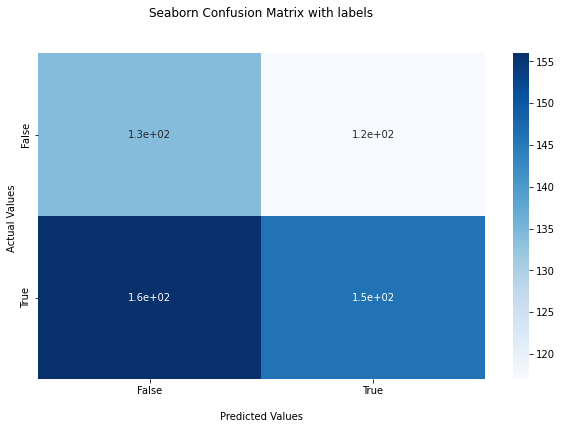

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.3f' % precision_score(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['Roberta_senti_change']))
print('Recall: %.3f' % recall_score(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['Roberta_senti_change']))
print('Accuracy: %.3f' % accuracy_score(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['Roberta_senti_change']))
print('F1 Score: %.3f' % f1_score(roberta_tesla_df['Actual_sentiment'],roberta_tesla_df['Roberta_senti_change']))

Precision: 0.555
Recall: 0.483
Accuracy: 0.506
F1 Score: 0.517
